### Previsão da capacidade de pagar um empréstimo

Projeto de classificação para definir se um determinado empréstimo será pago ou não pelo cliente a partir duma base de dados alternativos, possivelmente dados que não são usualmente utilizados por bancos e bureaus de créditos.

Fonte: https://www.kaggle.com/competitions/home-credit-default-risk/overview

Este projeto foi elaborado durante **uma semana** do curso de Ciência de Dados da Ada (Let's Code), logo o objetivo era aplicar diversas técnicas de tratamento e modelagem de dados para obter a melhor performance possível, além de fomentar o trabalho em equipe e o uso do Git.

<br>

- Principais técnicas aplicadas
    - Limpeza e tratamento de dados;
    - Balanceamento dos dados;
    - Substituição dos valores nulos/faltantes;
    - Transformação dos dados
    - Feature Engineering;
    - Feature Selection;
    - Redução de dimensionalidade (PCA);
    - Construção de pipelines;
    - Exploração de diferentes estimadores (Regressão Logística, RandomForest, KNC, SVC e XGBoost);
    - Otimização de hiperparâmetros (GridSearch e RandomSearch)

Obs: Se necessário, faça o download dos arquivos de treino (application_train) e teste (application_test_student) no site do Kaggle, pois os mesmos são grandes e passavam do limite do GitHub.

A seguir, apresentamos a maioria das análises que fizemos, sendo que algumas não são apresentadas por serem repetitivas e não terem agregado à análise

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, classification_report

from xgboost import XGBClassifier

In [3]:
df_application_train = pd.read_csv('application_train.csv')
df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,456162,0,Cash loans,F,N,N,0,112500.0,700830.0,22738.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,134978,0,Cash loans,F,N,N,0,90000.0,375322.5,14422.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
2,318952,0,Cash loans,M,Y,N,0,180000.0,544491.0,16047.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0
3,361264,0,Cash loans,F,N,Y,0,270000.0,814041.0,28971.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
4,260639,0,Cash loans,F,N,Y,0,144000.0,675000.0,21906.0,...,0,0,0,0,0.0,0.0,0.0,10.0,0.0,0.0


Após ver o significado de cada coluna, foram selecionadas aquelas que não fazem sentido (a priori)estarem relacionadas com a classificação desejada. Repare que as colunas não foram delatas de uma vez só, pois algumas necessitaram de uma discussão maior.

In [4]:
df_application_train = df_application_train.drop(columns = ['CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_FAMILY_STATUS', 'REGION_POPULATION_RELATIVE','DAYS_ID_PUBLISH', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 
                            'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
                            'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 
                            'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
                            'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG' , 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 
                            'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 
                            'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
                            'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
                            'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'FLAG_CONT_MOBILE'])


In [5]:
flags = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

df_application_train['NUMBER_OF_DOCUMENTS_GIVEN'] = df_application_train[flags].sum(axis='columns')
df_application_train = df_application_train.drop(columns = flags)

df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NUMBER_OF_DOCUMENTS_GIVEN
0,456162,0,Cash loans,N,N,0,112500.0,700830.0,22738.5,585000.0,...,0.0,0.0,-589.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,134978,0,Cash loans,N,N,0,90000.0,375322.5,14422.5,324000.0,...,0.0,0.0,-1409.0,0.0,0.0,0.0,1.0,0.0,3.0,1
2,318952,0,Cash loans,Y,N,0,180000.0,544491.0,16047.0,454500.0,...,1.0,1.0,-675.0,0.0,0.0,0.0,1.0,1.0,3.0,1
3,361264,0,Cash loans,N,Y,0,270000.0,814041.0,28971.0,679500.0,...,2.0,0.0,-1588.0,0.0,0.0,0.0,0.0,1.0,4.0,1
4,260639,0,Cash loans,N,Y,0,144000.0,675000.0,21906.0,675000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,1


In [6]:
bureau_enquires = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
df_application_train['TOTAL_BUREAU_ENQUIRES'] = (df_application_train[bureau_enquires].sum(axis='columns'))

df_application_train = df_application_train.drop(columns = bureau_enquires)

In [7]:
df_application_train = df_application_train.drop(columns = ['CNT_CHILDREN', 'DAYS_LAST_PHONE_CHANGE'])

In [8]:
df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,NUMBER_OF_DOCUMENTS_GIVEN,TOTAL_BUREAU_ENQUIRES
0,456162,0,Cash loans,N,N,112500.0,700830.0,22738.5,585000.0,Working,...,Trade: type 2,NaN,0.699373,0.171468,0.0,0.0,0.0,0.0,1,1.0
1,134978,0,Cash loans,N,N,90000.0,375322.5,14422.5,324000.0,Commercial associate,...,Business Entity Type 3,0.541385,0.199651,0.768808,0.0,0.0,0.0,0.0,1,4.0
2,318952,0,Cash loans,Y,N,180000.0,544491.0,16047.0,454500.0,Working,...,Business Entity Type 1,NaN,0.704880,0.626304,1.0,1.0,1.0,1.0,1,5.0
3,361264,0,Cash loans,N,Y,270000.0,814041.0,28971.0,679500.0,Pensioner,...,XNA,NaN,0.724576,0.810618,2.0,0.0,2.0,0.0,1,5.0
4,260639,0,Cash loans,N,Y,144000.0,675000.0,21906.0,675000.0,Working,...,Transport: type 4,0.592466,0.706310,0.331251,0.0,0.0,0.0,0.0,1,10.0


Além do critério de features que não fazem sentido com a classificação, agrupou-se algumas features que significavam coisas muito similares, assim como mostrado nas células acima. Por exemplo, juntou-se os números de documentos fornecidos em apenas uma e o mesmo foi feito com o número de consultas a agências de crédito.

A seguir, algumas outras análises para ainda diminuir o número de features são feitas, como: quantidade de NaN e identificar outras similaridades

In [9]:
df_application_train.isna().sum().sort_values(ascending=False)/df_application_train.shape[0]

OWN_CAR_AGE                  0.659974
EXT_SOURCE_1                 0.564221
EXT_SOURCE_3                 0.198075
DEF_60_CNT_SOCIAL_CIRCLE     0.003305
OBS_60_CNT_SOCIAL_CIRCLE     0.003305
DEF_30_CNT_SOCIAL_CIRCLE     0.003305
OBS_30_CNT_SOCIAL_CIRCLE     0.003305
EXT_SOURCE_2                 0.002211
AMT_GOODS_PRICE              0.000919
AMT_ANNUITY                  0.000041
CNT_FAM_MEMBERS              0.000004
FLAG_EMAIL                   0.000000
SK_ID_CURR                   0.000000
ORGANIZATION_TYPE            0.000000
FLAG_WORK_PHONE              0.000000
NUMBER_OF_DOCUMENTS_GIVEN    0.000000
FLAG_PHONE                   0.000000
FLAG_MOBIL                   0.000000
FLAG_EMP_PHONE               0.000000
TARGET                       0.000000
DAYS_REGISTRATION            0.000000
DAYS_EMPLOYED                0.000000
DAYS_BIRTH                   0.000000
NAME_HOUSING_TYPE            0.000000
NAME_EDUCATION_TYPE          0.000000
NAME_INCOME_TYPE             0.000000
AMT_CREDIT  

In [10]:
df_application_train = df_application_train.drop(columns=['EXT_SOURCE_1','OWN_CAR_AGE'])

Aqui, foi feito um estudo da distribuição dos dados sobre o círculo social da pessoa. O objetivo foi ver se a distribuição dos dados era similar, indicando que algumas das colunas poderiam ser deletadas. De fato, viu-se que seria possível reduzir elas, mas este documento apresenta as 4, pois não foi obtido um ganho considerável com essa limpeza.

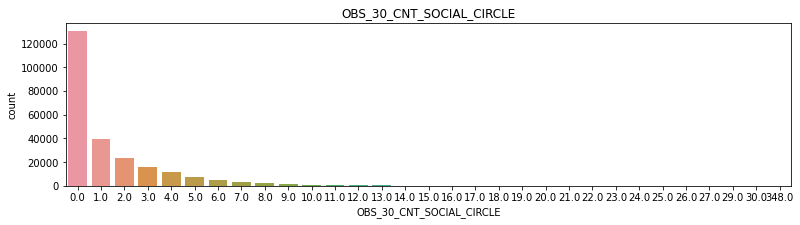

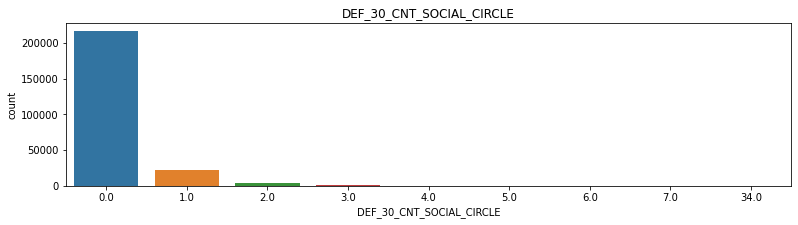

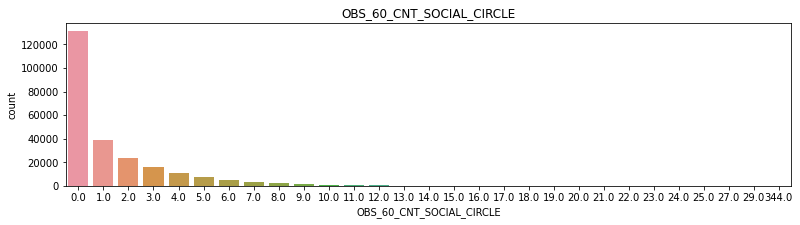

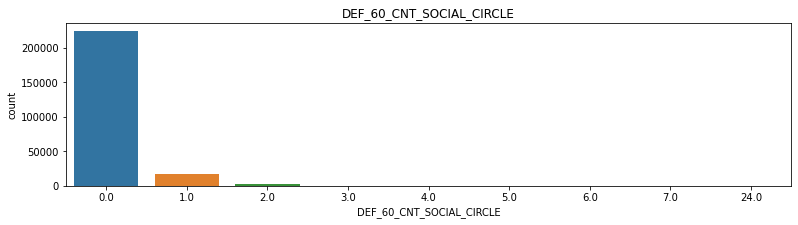

In [11]:
variaveis = ['OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE']

for variavel in variaveis:
       plt.figure(figsize=(13, 3))
       fig = sns.countplot(x=df_application_train[variavel])
       fig.set_title(variavel)
       plt.show()

Análises baseadas na distribuição dos dados:

In [12]:
df_application_train.describe()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,FLAG_MOBIL,...,FLAG_EMAIL,CNT_FAM_MEMBERS,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,NUMBER_OF_DOCUMENTS_GIVEN,TOTAL_BUREAU_ENQUIRES
count,246008.000000,246008.000000,2.460080e+05,2.460080e+05,245998.000000,2.457820e+05,246008.000000,246008.000000,246008.000000,246008.000000,...,246008.000000,246007.000000,2.454640e+05,197280.000000,245195.000000,245195.000000,245195.000000,245195.000000,246008.000000,246008.000000
mean,278280.072908,0.081176,1.689122e+05,5.996283e+05,27129.162648,5.389289e+05,-16042.794393,63963.755699,-4988.033300,0.999996,...,0.056722,2.150760,5.143916e-01,0.510838,1.423598,0.144045,1.406803,0.100691,0.930319,2.144967
std,102790.909988,0.273106,2.603818e+05,4.030672e+05,14504.965232,3.699738e+05,4365.973763,141400.318322,3520.987048,0.002016,...,0.231311,0.909167,1.908912e-01,0.194880,2.423894,0.449464,2.402398,0.364917,0.343988,2.241591
min,100002.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,-25229.000000,-17912.000000,-23738.000000,0.000000,...,0.000000,1.000000,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189165.500000,0.000000,1.125000e+05,2.700000e+05,16561.125000,2.385000e+05,-19691.000000,-2758.000000,-7481.000000,1.000000,...,0.000000,2.000000,3.926530e-01,0.370650,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,278392.500000,0.000000,1.485000e+05,5.147775e+05,24930.000000,4.500000e+05,-15763.000000,-1215.000000,-4503.000000,1.000000,...,0.000000,2.000000,5.657089e-01,0.535276,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,367272.250000,0.000000,2.025000e+05,8.086500e+05,34599.375000,6.795000e+05,-12418.000000,-289.000000,-2018.000000,1.000000,...,0.000000,3.000000,6.634999e-01,0.669057,2.000000,0.000000,2.000000,0.000000,1.000000,3.000000
max,456255.000000,1.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,-7489.000000,365243.000000,0.000000,1.000000,...,1.000000,20.000000,8.549997e-01,0.896010,348.000000,34.000000,344.000000,24.000000,4.000000,31.000000


(array([201609.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  44399.]),
 array([-17912. ,  20403.5,  58719. ,  97034.5, 135350. , 173665.5,
        211981. , 250296.5, 288612. , 326927.5, 365243. ]),
 <BarContainer object of 10 artists>)

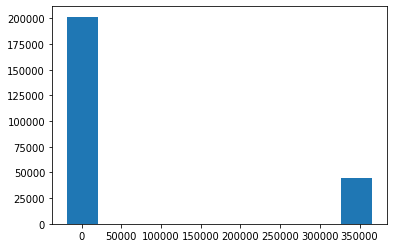

In [13]:
plt.hist(data=df_application_train, x='DAYS_EMPLOYED')

In [14]:
pensionistas = df_application_train[df_application_train['NAME_INCOME_TYPE']=='Pensioner']
print(pensionistas.shape)
print(pensionistas[pensionistas['DAYS_EMPLOYED']==365243].shape)

(44389, 30)
(44382, 30)


In [15]:
df_application_train = df_application_train.drop(columns=['DAYS_EMPLOYED'])

Excluiu-se a coluna 'DAYS_EMPLOYED' porque descobriu-se que pensionistas ('Pensioner') estão com o valor de 365243 dias (valor irreal), o que atrapalharia trabalhar misturado com outros tipos de fonte de renda que contam com valores em dias reais

In [16]:
df_application_train['AGE_IN_YEARS'] = df_application_train['DAYS_BIRTH']/-365
df_application_train.drop(columns='DAYS_BIRTH', inplace=True)

In [17]:
df_application_train.drop(119496, inplace = True) # Essa linha é a que contém dados absurdos do círculo social

In [18]:
df_application_train = df_application_train.drop(columns=['SK_ID_CURR','ORGANIZATION_TYPE'])
df_application_train['DAYS_REGISTRATION'] = df_application_train['DAYS_REGISTRATION']*(-1)

In [ ]:
dict_cat = {'Higher education':3, 'Academic degree':3, 'Incomplete higher':2, 'Secondary / secondary special':1, 'Lower secondary':0}
df_application_train['NAME_EDUCATION_TYPE'] = df_application_train['NAME_EDUCATION_TYPE'].map(dict_cat)

# O mapeamento/rename acima serve para transformar a variável categóriga ordinal em quantitativa

### A partir de agora, são feitas as etapas para criar os modelos

In [20]:
df_application_train['TARGET'].value_counts()

0    226037
1     19970
Name: TARGET, dtype: int64

Uma observação interessante de se falar é que tentou-se criar novas features para melhorar o modelo, como exemplo uma coluna com a renda per capita da família, para ver se ela poderia substituir 'AMT_INCOME_TOTAL' e 'CNT_FAM_MEMBERS',
além de apresentar melhores resultados. No entanto, não houve mudança positiva significativa, então não é apresentada.

In [21]:
df_train, df_test = train_test_split(df_application_train, test_size=0.2, random_state=42, stratify=df_application_train['TARGET'])

In [22]:
display(df_train['TARGET'].value_counts(normalize=True))
display(df_test['TARGET'].value_counts(normalize=True))

0    0.918823
1    0.081177
Name: TARGET, dtype: float64

0    0.918824
1    0.081176
Name: TARGET, dtype: float64

In [23]:
n_zero, n_um = df_train['TARGET'].value_counts()

df_train_1 = df_train[df_train['TARGET'] == 1].copy()
df_train_0 = df_train[df_train['TARGET'] == 0].sample(n=n_um, replace=False, random_state=42).copy()

df_balanceado = pd.concat([df_train_1, df_train_0])

df_balanceado['TARGET'].value_counts()

1    15976
0    15976
Name: TARGET, dtype: int64

In [24]:
X_train = df_balanceado.drop(columns=['TARGET'], axis=1)
X_test = df_test.drop(columns=['TARGET'], axis=1)

y_train = df_balanceado['TARGET']
y_test = df_test['TARGET']

In [25]:
features_num = X_train.select_dtypes(include=np.number).columns.tolist()
features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

feature_source_3 = ['EXT_SOURCE_3']
features_num.remove('EXT_SOURCE_3')

In [26]:
pipe_tr_features_num = Pipeline([
    ('tr_imput_median', SimpleImputer(strategy='median')),
    ('tr_standardScaler', StandardScaler())
])

pipe_source3 = Pipeline([
    ('tr_imput_median', KNNImputer(n_neighbors=2)),
    ('tr_standardScaler', StandardScaler())
])

pipe_tr_features_cat = Pipeline([
    ('tr_input_frequent', SimpleImputer(strategy='most_frequent')),
    ('tr_dummy', OneHotEncoder(drop='first'))
])

pre_processor = ColumnTransformer([
    ('tr_num', pipe_tr_features_num, features_num),
    ('tr_source3', pipe_source3, feature_source_3),
    ('tr_cat', pipe_tr_features_cat, features_cat)
])

pipe_final = Pipeline([
    ('pre_processor', pre_processor),
    ('est', RandomForestClassifier(random_state=42))
])

In [27]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('tr_num',
                                                  Pipeline(steps=[('tr_imput_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('tr_standardScaler',
                                                                   StandardScaler())]),
                                                  ['AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'DAYS_REGISTRATION',
                                                   'FLAG_MOBIL',
                                                   'FLAG_EMP_PHONE',
                                                   'FLAG_WORK_PHONE',
                                                   'FLAG_PHON...
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('tr_standardScaler',
                                                                   StandardScaler())]),
                                                  ['EXT_SOURCE_3']),
                                                 ('tr_cat',
                                                  Pipeline(steps=[('tr_input_frequent',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('tr_dummy',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_HOUSING_TYPE'])])),
                ('est', RandomForestClassifier(random_state=42))])

In [28]:
y_pred = pipe_final.predict(X_test)

print(classification_report(y_test, y_pred))

rocRF = roc_auc_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     45208
           1       0.15      0.65      0.25      3994

    accuracy                           0.68     49202
   macro avg       0.56      0.67      0.52     49202
weighted avg       0.89      0.68      0.75     49202



Criou-se um primeiro modelo (acima) baseado em RandomForest. Vamos agora observar as importância das features para ver se é  possível excluir algumas delas

In [29]:
features = list(features_num + feature_source_3 + pipe_final.named_steps['pre_processor'].transformers_[2][1].named_steps['tr_dummy'].get_feature_names(features_cat).tolist())

importancias = pipe_final[1].feature_importances_.tolist()
nova_lista = list(zip(features,importancias))
nova_lista.sort(key = lambda x:x[1] , reverse=True)
nova_lista

c:\Users\Daniel Garcia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('EXT_SOURCE_2', 0.13723273662434862),
 ('EXT_SOURCE_3', 0.12974894420648683),
 ('AGE_IN_YEARS', 0.0938867766429708),
 ('DAYS_REGISTRATION', 0.08448589489165491),
 ('AMT_ANNUITY', 0.08271752362223732),
 ('AMT_CREDIT', 0.07430806216760372),
 ('AMT_GOODS_PRICE', 0.06389814266437399),
 ('AMT_INCOME_TOTAL', 0.0638383809576439),
 ('TOTAL_BUREAU_ENQUIRES', 0.041267045025500854),
 ('CNT_FAM_MEMBERS', 0.02772733911991965),
 ('OBS_30_CNT_SOCIAL_CIRCLE', 0.027360159407576856),
 ('OBS_60_CNT_SOCIAL_CIRCLE', 0.027245389325492905),
 ('NAME_EDUCATION_TYPE', 0.018108569202892062),
 ('FLAG_OWN_REALTY_Y', 0.012923999232202834),
 ('FLAG_OWN_CAR_Y', 0.012548949121571333),
 ('FLAG_PHONE', 0.011709204828955709),
 ('FLAG_WORK_PHONE', 0.010116129540650123),
 ('NAME_INCOME_TYPE_Working', 0.009276989936606103),
 ('DEF_30_CNT_SOCIAL_CIRCLE', 0.008807629813217983),
 ('NUMBER_OF_DOCUMENTS_GIVEN', 0.008092252455651417),
 ('NAME_INCOME_TYPE_Commercial associate', 0.007275284782165358),
 ('NAME_HOUSING_TYPE_House /

Vendo as importâncias, resolveu-se trabalhar com as 10 primeiras features porque elas representam 80% da importância do modelo, assim como é mostrado na célula abaixo.

In [30]:
print(f'Somatório até 10ª feature: {sum(x[1] for x in nova_lista[:10])}')

Somatório até 10ª feature: 0.7991108459227405


In [31]:
features_num_top10 = [x[0] for x in nova_lista[:10]]
features_num_top10

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'AGE_IN_YEARS',
 'DAYS_REGISTRATION',
 'AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'TOTAL_BUREAU_ENQUIRES',
 'CNT_FAM_MEMBERS']

In [32]:
X_train_top10 = X_train[features_num_top10]
X_test_top10 = X_test[features_num_top10]

pre_processor2 = ColumnTransformer([
    ('tr_num', pipe_tr_features_num, features_num_top10)
])

pipe_final_RFC = Pipeline([
    ('pre_processor', pre_processor2),
    ('est', RandomForestClassifier(random_state=42, max_depth = 4))
])

pipe_final_RFC.fit(X_train_top10, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('tr_num',
                                                  Pipeline(steps=[('tr_imput_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('tr_standardScaler',
                                                                   StandardScaler())]),
                                                  ['EXT_SOURCE_2',
                                                   'EXT_SOURCE_3',
                                                   'AGE_IN_YEARS',
                                                   'DAYS_REGISTRATION',
                                                   'AMT_ANNUITY', 'AMT_CREDIT',
                                                   'AMT_GOODS_PRICE',
                                                   'AMT_INCOME_TOTAL',
                                                   'TOTAL_BUREAU_ENQUIRES',
                                                   'CNT_FAM_MEMBERS'])])),
                ('est', RandomForestClassifier(max_depth=4, random_state=42))])

In [33]:
y_pred2 = pipe_final_RFC.predict(X_test_top10)

print(classification_report(y_test, y_pred2))

ROC_RF = roc_auc_score(y_test, y_pred2)
print(ROC_RF)

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     45208
           1       0.15      0.66      0.24      3994

    accuracy                           0.67     49202
   macro avg       0.55      0.66      0.52     49202
weighted avg       0.89      0.67      0.74     49202

0.6646180228580351


Com o resultado acima, vemos que o valor da AUROC teve uma leve melhora, mostrando que o modelo não foi prejudicado.

O próximo passo foi realizar uma redução de dimensionalidade nessas 10 features para ver se a separação das classes melhorava

In [34]:
X_train_transf = pre_processor2.fit_transform(X_train)
pca = PCA(n_components = 10, random_state=42)
pca.fit(X_train_transf)
componentes = pca.transform(X_train_transf)
labels = [f'PC{i+1}' for i in range(X_train_transf.shape[1])]
df_pca = pd.DataFrame(data=componentes, columns=labels)
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-1.653143,-0.132235,2.625761,0.308662,-0.248989,-0.086200,0.329497,-2.260039,-0.303589,-0.040905
1,-2.283120,1.124549,0.386620,-0.462800,1.772931,-0.024106,-1.137929,-1.052546,-0.293200,0.060130
2,-0.747179,-2.003811,-0.628900,-0.760166,-0.615883,-1.525064,-0.327342,0.557227,-0.290064,0.125034
3,-1.949747,0.494688,1.468946,-0.704640,1.666359,0.811763,-0.624715,-0.641051,-0.327206,0.067598
4,0.112059,0.225206,-0.043292,0.620597,-0.620229,0.770810,0.156467,-0.524865,0.195996,-0.247395


In [35]:
pca.explained_variance_ratio_

array([0.29638922, 0.16064275, 0.10940123, 0.1018531 , 0.08778454,
       0.08161072, 0.07017858, 0.06176478, 0.02889392, 0.00148115])

In [36]:
X_test_transf = pre_processor2.fit_transform(X_test)
componentes_teste = pca.transform(X_test_transf)
df_pca_test = pd.DataFrame(data=componentes_teste, columns=labels)
df_pca_test.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-1.421956,0.614878,1.054609,-0.836383,1.907709,1.227410,-0.121589,-1.372748,-0.378277,0.072898
1,-1.754194,1.239218,1.107631,-0.776287,0.642322,1.426470,0.456096,-1.127538,-0.407887,0.071929
2,-1.560747,0.205539,-0.928002,0.535842,0.191734,0.438594,0.125250,1.188598,0.235604,0.039665
3,-0.026113,0.743749,0.831708,0.849305,-0.018090,-1.029646,-0.468859,-0.329726,-0.129007,-0.045005
4,-1.947876,1.595453,-0.600903,-1.524957,-0.157042,-0.480259,1.353329,-0.457841,-0.066921,-0.026052


In [37]:
modelo = RandomForestClassifier(random_state=42, max_depth = 4).fit(df_pca, y_train)

y_pred_RF = modelo.predict(df_pca_test)

print(classification_report(y_test, y_pred_RF))

ROC_RF_PCA = roc_auc_score(y_test, y_pred_RF)
print(ROC_RF_PCA)

              precision    recall  f1-score   support

           0       0.96      0.57      0.72     45208
           1       0.13      0.73      0.22      3994

    accuracy                           0.59     49202
   macro avg       0.55      0.65      0.47     49202
weighted avg       0.89      0.59      0.68     49202

0.6531000380414897


In [38]:
print(f'O ROC do modelo Random Forest utilizando as features originais é: {ROC_RF:.3f} e o ROC utilizando as features com PCA é {ROC_RF_PCA:.3f}.')

O ROC do modelo Random Forest utilizando as features originais é: 0.665 e o ROC utilizando as features com PCA é 0.653.


Com o resultado acima, vemos que utilizar o PCA não resultou numa melhora dos resultados. Tentou-se também reduzir o número de componentes principais baseado na variância, mas o resultado não melhorou. Desta forma, decidiu-se trabalhar com as 10 features originais mesmo.

Os passos seguintes foram testar diferentes tipos de estimadores com seus hiperparâmetros padrões.

In [39]:
pipe_final_reg_logistic = Pipeline([
    ('pre_processor', pre_processor2),
    ('est', LogisticRegression())
])

pipe_final_reg_logistic.fit(X_train_top10, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('tr_num',
                                                  Pipeline(steps=[('tr_imput_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('tr_standardScaler',
                                                                   StandardScaler())]),
                                                  ['EXT_SOURCE_2',
                                                   'EXT_SOURCE_3',
                                                   'AGE_IN_YEARS',
                                                   'DAYS_REGISTRATION',
                                                   'AMT_ANNUITY', 'AMT_CREDIT',
                                                   'AMT_GOODS_PRICE',
                                                   'AMT_INCOME_TOTAL',
                                                   'TOTAL_BUREAU_ENQUIRES',
                                                   'CNT_FAM_MEMBERS'])])),
                ('est', LogisticRegression())])

In [40]:
y_pred_reg_logistic = pipe_final_reg_logistic.predict(X_test_top10)

print(classification_report(y_test, y_pred_reg_logistic))

ROC_reg_log = roc_auc_score(y_test, y_pred_reg_logistic)

print(ROC_reg_log)

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     45208
           1       0.15      0.65      0.25      3994

    accuracy                           0.68     49202
   macro avg       0.55      0.67      0.52     49202
weighted avg       0.89      0.68      0.75     49202

0.6650499273507677


In [41]:
pipe_final_KNeighborsClassifier = Pipeline([
    ('pre_processor', pre_processor2),
    ('est', KNeighborsClassifier())
])

pipe_final_KNeighborsClassifier.fit(X_train_top10, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('tr_num',
                                                  Pipeline(steps=[('tr_imput_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('tr_standardScaler',
                                                                   StandardScaler())]),
                                                  ['EXT_SOURCE_2',
                                                   'EXT_SOURCE_3',
                                                   'AGE_IN_YEARS',
                                                   'DAYS_REGISTRATION',
                                                   'AMT_ANNUITY', 'AMT_CREDIT',
                                                   'AMT_GOODS_PRICE',
                                                   'AMT_INCOME_TOTAL',
                                                   'TOTAL_BUREAU_ENQUIRES',
                                                   'CNT_FAM_MEMBERS'])])),
                ('est', KNeighborsClassifier())])

In [42]:
y_pred_KNeighborsClassifier = pipe_final_KNeighborsClassifier.predict(X_test_top10)

print(classification_report(y_test, y_pred_KNeighborsClassifier))

ROC_KNN = roc_auc_score(y_test, y_pred_KNeighborsClassifier)

print(ROC_KNN)

              precision    recall  f1-score   support

           0       0.95      0.61      0.74     45208
           1       0.12      0.62      0.21      3994

    accuracy                           0.61     49202
   macro avg       0.54      0.61      0.48     49202
weighted avg       0.88      0.61      0.70     49202

0.6148540520035053


In [209]:
pipe_final_SVC = Pipeline([
    ('pre_processor', pre_processor2),
    ('est', SVC())
])

pipe_final_SVC.fit(X_train_top10, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('tr_num',
                                                  Pipeline(steps=[('tr_imput_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('tr_standardScaler',
                                                                   StandardScaler())]),
                                                  ['EXT_SOURCE_2',
                                                   'EXT_SOURCE_3',
                                                   'AGE_IN_YEARS',
                                                   'DAYS_REGISTRATION',
                                                   'AMT_ANNUITY', 'AMT_CREDIT',
                                                   'AMT_GOODS_PRICE',
                                                   'AMT_INCOME_TOTAL',
                                                   'TOTAL_BUREAU_ENQUIRES',
                                                   'CNT_FAM_MEMBERS'])])),
                ('est', SVC())])

In [210]:
y_pred_SVC = pipe_final_SVC.predict(X_test_top10)

print(classification_report(y_test, y_pred_SVC))

ROC_SVC = roc_auc_score(y_test, y_pred_SVC)

print(ROC_SVC)

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     45208
           1       0.15      0.65      0.25      3994

    accuracy                           0.68     49202
   macro avg       0.56      0.67      0.52     49202
weighted avg       0.89      0.68      0.75     49202

0.6677431316856721


In [211]:
pipe_final_XGBClassifier = Pipeline([
    ('pre_processor', pre_processor2),
    ('est', XGBClassifier(nthread=14))
])

pipe_final_XGBClassifier.fit(X_train_top10, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('tr_num',
                                                  Pipeline(steps=[('tr_imput_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('tr_standardScaler',
                                                                   StandardScaler())]),
                                                  ['EXT_SOURCE_2',
                                                   'EXT_SOURCE_3',
                                                   'AGE_IN_YEARS',
                                                   'DAYS_REGISTRATION',
                                                   'AMT_ANNUITY', 'AMT_CREDIT',
                                                   'AMT_GOODS_PRICE',
                                                   'AMT_INCOME_TOTAL',
                                                   'TOTAL_BUREAU_ENQUIRES',
                                                   'CNT_FAM_ME...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=14, nthread=14, num_parallel_tree=1,
                               predictor='auto', ...))])

In [212]:
y_pred_XGBClassifier = pipe_final_XGBClassifier.predict(X_test_top10)

print(classification_report(y_test, y_pred_XGBClassifier))

ROC_XGB = roc_auc_score(y_test, y_pred_XGBClassifier)

print(ROC_XGB)

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     45208
           1       0.15      0.65      0.24      3994

    accuracy                           0.67     49202
   macro avg       0.55      0.66      0.52     49202
weighted avg       0.89      0.67      0.75     49202

0.6624042084184497


In [213]:
print('Os valores da área ROC obtidos foram:,\n'
f'ROC Random Forest = {ROC_RF:.3f}','\n'
f'ROC Regressão Logística = {ROC_reg_log:.3f}','\n'
f'ROC KNN = {ROC_KNN:.3f}','\n'
f'ROC SVC = {ROC_SVC:.3f}','\n'
f'ROC XGBoosting = {ROC_XGB:.3f}'
)

Os valores da área ROC obtidos foram:,
ROC Random Forest = 0.665 
ROC Regressão Logística = 0.665 
ROC KNN = 0.615 
ROC SVC = 0.668 
ROC XGBoosting = 0.662


Foram testados 5 estimadores diferentes e viu-se que o modelo do RandomForest se performou melhor segundo a AUROC, excluindo o SVC. Dessa forma, faremos uma otimização desse estimador, levando em conta também que ele teve um tempo rápido de "fit" e "predict".

In [214]:
espaco_hiper = {
    'est__n_estimators': range(1, 200),
    'est__max_depth': range(1, 8)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Poderia ser usado o KFold já que balanceamos

random_RFC1 = RandomizedSearchCV(
    estimator=pipe_final_RFC,
    param_distributions=espaco_hiper,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=14,
    n_iter=400
)

random_RFC1.fit(X_train_top10, y_train)

y_pred_random_RF1 = random_RFC1.predict(X_test_top10)
print(classification_report(y_test, y_pred_random_RF1))

random_RFC1.best_params_

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     45208
           1       0.15      0.66      0.25      3994

    accuracy                           0.67     49202
   macro avg       0.55      0.67      0.52     49202
weighted avg       0.89      0.67      0.75     49202



{'est__n_estimators': 199, 'est__max_depth': 7}

In [218]:
ROC_random_RF = roc_auc_score(y_test, y_pred_random_RF1)

print(f'ROC do Random Forest com hiperparâmetros otimizados = {ROC_random_RF:.3f}')
print(f'ROC do Random Forest com hiperparâmetros padrão ={ROC_RF:.3f}')

ROC do Random Forest com hiperparâmetros otimizados = 0.667
ROC do Random Forest com hiperparâmetros padrão =0.665


In [217]:
espaco_hiper = {
    'est__n_estimators': range(190, 400),
    'est__max_depth': range(4, 8)
}

random_RFC2 = RandomizedSearchCV(
    estimator=pipe_final_RFC,
    param_distributions=espaco_hiper,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=14,
    n_iter=400
)

random_RFC2.fit(X_train_top10, y_train)

y_pred_random_RF2 = random_RFC2.predict(X_test_top10)
print(classification_report(y_test, y_pred_random_RF2))

random_RFC2.best_params_

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     45208
           1       0.15      0.66      0.25      3994

    accuracy                           0.67     49202
   macro avg       0.55      0.67      0.52     49202
weighted avg       0.89      0.67      0.75     49202



{'est__n_estimators': 211, 'est__max_depth': 7}

In [219]:
ROC_random_RF2 = roc_auc_score(y_test, y_pred_random_RF2)

print(f'ROC do Random Forest com hiperparâmetros otimizados = {ROC_random_RF2:.3f}')
print(f'ROC do Random Forest com hiperparâmetros padrão ={ROC_RF:.3f}')

ROC do Random Forest com hiperparâmetros otimizados = 0.667
ROC do Random Forest com hiperparâmetros padrão =0.665


Dessa forma, com duas tentativas de otimização com um range grande e com várias iterações, foi encontrado uma área da curva ROC de 0,667.

In [227]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
espaco_hiper = {
    'est__learning_rate': [0.01, 0.1, 0.2],
    'est__alpha': [0.01, 0.3, 0.8],
    'est__colsample_bytree': [0.1, 0.4, 0.8],
    'est__n_estimators': [50, 100, 200],
    'est__max_depth': [1, 4, 7]
}


random_XGB = GridSearchCV(
    estimator=pipe_final_XGBClassifier,
    param_grid=espaco_hiper,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=6
)

random_XGB.fit(X_train_top10, y_train)

y_pred_random_XGB = random_XGB.predict(X_test_top10)
print(classification_report(y_test, y_pred_random_XGB))

random_XGB.best_params_


              precision    recall  f1-score   support

           0       0.96      0.68      0.80     45208
           1       0.16      0.66      0.25      3994

    accuracy                           0.68     49202
   macro avg       0.56      0.67      0.52     49202
weighted avg       0.89      0.68      0.75     49202



{'est__alpha': 0.01,
 'est__colsample_bytree': 0.4,
 'est__learning_rate': 0.1,
 'est__max_depth': 4,
 'est__n_estimators': 100}

In [228]:
ROC_random_XGB = roc_auc_score(y_test, y_pred_random_XGB)

print(f'ROC do XGBoosting com hiperparâmetros otimizados = {ROC_random_XGB:.3f}')
print(f'ROC do XGBoosting com hiperparâmetros padrão ={ROC_XGB:.3f}')

ROC do Random Forest com hiperparâmetros otimizados = 0.673
ROC do Random Forest com hiperparâmetros padrão =0.662


In [238]:
espaco_hiper = {
    'est__learning_rate': np.arange(0.01, 0.2),
    'est__alpha': np.arange(0.01, 0.8),
    'est__colsample_bytree': np.arange(0.1, 0.8),
    'est__n_estimators': np.arange(50, 200),
    'est__max_depth': np.arange(1, 7)
}


random_XGB2 = RandomizedSearchCV(
    estimator=pipe_final_XGBClassifier,
    param_distributions=espaco_hiper,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=14,
    n_iter=400
)

random_XGB2.fit(X_train_top10, y_train)

y_pred_random_XGB2 = random_XGB2.predict(X_test_top10)
print(classification_report(y_test, y_pred_random_XGB2))

random_XGB2.best_params_

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     45208
           1       0.15      0.66      0.24      3994

    accuracy                           0.67     49202
   macro avg       0.55      0.66      0.51     49202
weighted avg       0.89      0.67      0.74     49202



{'est__n_estimators': 136,
 'est__max_depth': 4,
 'est__learning_rate': 0.01,
 'est__colsample_bytree': 0.1,
 'est__alpha': 0.01}

In [240]:
ROC_random_XGB2 = roc_auc_score(y_test, y_pred_random_XGB2)

print(f'ROC do XGBoosting com hiperparâmetros otimizados = {ROC_random_XGB2:.3f}')
print(f'ROC do XGBoosting com hiperparâmetros padrão ={ROC_XGB:.3f}')

ROC do XGBoosting com hiperparâmetros otimizados = 0.663
ROC do XGBoosting com hiperparâmetros padrão =0.662


In [242]:
resultado = random_XGB2.predict_proba(X_test_top10)[:,1]

(49202,)

## Predizendo o teste

In [43]:
df_application_test = pd.read_csv('application_test_student.csv')
df_application_test.head()


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,149741,Cash loans,F,N,N,0,117000.0,417024.0,20191.5,360000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,363290,Cash loans,M,N,Y,0,450000.0,640080.0,31261.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,436006,Revolving loans,M,Y,Y,0,450000.0,900000.0,45000.0,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0
3,377703,Cash loans,M,Y,N,1,360000.0,1125000.0,33025.5,1125000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,188624,Cash loans,M,Y,Y,0,675000.0,835380.0,42840.0,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [44]:
df_application_test['AGE_IN_YEARS'] = df_application_test['DAYS_BIRTH']/-365
df_application_test = df_application_test.drop(columns='DAYS_BIRTH')

In [45]:
bureau_enquires = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
df_application_test['TOTAL_BUREAU_ENQUIRES'] = (df_application_test[bureau_enquires].sum(axis='columns'))

df_application_test = df_application_test.drop(columns = bureau_enquires)

df_application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AGE_IN_YEARS,TOTAL_BUREAU_ENQUIRES
0,149741,Cash loans,F,N,N,0,117000.0,417024.0,20191.5,360000.0,...,0,0,0,0,0,0,0,0,59.654795,3.0
1,363290,Cash loans,M,N,Y,0,450000.0,640080.0,31261.5,450000.0,...,0,0,0,0,0,0,0,0,50.682192,1.0
2,436006,Revolving loans,M,Y,Y,0,450000.0,900000.0,45000.0,900000.0,...,0,0,0,0,0,0,0,0,49.545205,2.0
3,377703,Cash loans,M,Y,N,1,360000.0,1125000.0,33025.5,1125000.0,...,0,0,0,0,0,0,0,0,33.750685,1.0
4,188624,Cash loans,M,Y,Y,0,675000.0,835380.0,42840.0,675000.0,...,0,0,0,0,0,0,0,0,27.810959,2.0


In [46]:
df_test = df_application_test[['SK_ID_CURR']+features_num_top10]
df_test.head()

,SK_ID_CURR,EXT_SOURCE_2,EXT_SOURCE_3,AGE_IN_YEARS,DAYS_REGISTRATION,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,TOTAL_BUREAU_ENQUIRES,CNT_FAM_MEMBERS
0,149741,0.182710,0.145543,59.654795,-4611.0,20191.5,417024.0,360000.0,117000.0,3.0,2.0
1,363290,0.669053,0.680139,50.682192,-3052.0,31261.5,640080.0,450000.0,450000.0,1.0,2.0
2,436006,0.454279,0.173527,49.545205,-8525.0,45000.0,900000.0,900000.0,450000.0,2.0,1.0
3,377703,0.688145,0.440058,33.750685,-12304.0,33025.5,1125000.0,1125000.0,360000.0,1.0,3.0
4,188624,0.426409,0.081726,27.810959,-2789.0,42840.0,835380.0,675000.0,675000.0,2.0,1.0


In [50]:
y_pred_resposta = random_XGB2.predict(df_test[features_num_top10])
resultado_proba = random_XGB2.predict_proba(df_test[features_num_top10])
print(resultado_proba)

[[0.40567863 0.59432137]
 [0.5245832  0.4754168 ]
 [0.47296882 0.5270312 ]
 ...
 [0.53070205 0.46929795]
 [0.4781512  0.5218488 ]
 [0.47337842 0.5266216 ]]


In [57]:
pd.DataFrame(data = resultado_proba[:,1],columns=['TARGET'], index=df_test['SK_ID_CURR']).to_csv("teste.csv")

### Exportando o .csv requerido

In [58]:
pd.DataFrame(data = resultado_proba[:,1],columns=['TARGET'], index=df_test['SK_ID_CURR']).to_csv("target_proba.csv")
pd.DataFrame(data = y_pred_resposta, columns=['TARGET'], index=df_test['SK_ID_CURR']).to_csv("target_predito.csv")

### Salvado o modelo em um arquivo pickle e mostrando como abrí-lo futuramente

In [ ]:
import pickle 
estimador_resposta = random_XGB2
arquivo = open('estimador_resposta.pickle', 'wb') 
pickle.dump(estimador_resposta, arquivo)

In [49]:
with open('estimador_resposta.pickle', 'rb') as f:
    estimador = pickle.load(f)